##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Forecasting with machine learning

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c05_forecasting_with_machine_learning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c05_forecasting_with_machine_learning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Setup

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [3]:
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [8]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

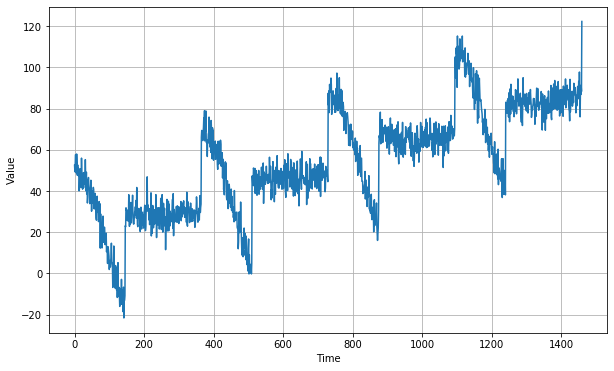

In [9]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

## Forecasting with Machine Learning

First, we will train a model to forecast the next step given the previous 30 steps, therefore, we need to create a dataset of 30-step windows for training.

In [10]:
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [11]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

### Linear Model

In [12]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
model.fit(train_set, epochs=100, validation_data=valid_set)

Epoch 1/100
31/31 [==============================] - 2s 56ms/step - loss: 46.5854 - mae: 47.9542 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/100
31/31 [==============================] - 0s 5ms/step - loss: 11.8285 - mae: 11.9459 - val_loss: 9.2357 - val_mae: 9.6871
Epoch 3/100
31/31 [==============================] - 0s 5ms/step - loss: 10.1682 - mae: 10.3805 - val_loss: 9.1530 - val_mae: 9.6008
Epoch 4/100
31/31 [==============================] - 0s 5ms/step - loss: 9.8548 - mae: 10.2880 - val_loss: 9.2402 - val_mae: 9.5627
Epoch 5/100
31/31 [==============================] - 0s 5ms/step - loss: 9.3782 - mae: 10.1772 - val_loss: 8.8791 - val_mae: 9.4029
Epoch 6/100
31/31 [==============================] - 0s 5ms/step - loss: 9.5393 - mae: 10.0866 - val_loss: 8.9816 - val_mae: 9.3764
Epoch 7/100
31/31 [==============================] - 0s 5ms/step - loss: 9.4518 - mae: 9.9598 - val_loss: 9.1477 - val_mae: 9.6448
Epoch 8/100
31/31 [==============================] - 0s 5ms/step 

Epoch 63/100
31/31 [==============================] - 0s 5ms/step - loss: 5.8499 - mae: 6.2962 - val_loss: 6.0042 - val_mae: 6.3899
Epoch 64/100
31/31 [==============================] - 0s 8ms/step - loss: 5.9194 - mae: 6.2138 - val_loss: 5.8279 - val_mae: 6.3414
Epoch 65/100
31/31 [==============================] - 0s 8ms/step - loss: 5.6132 - mae: 6.2228 - val_loss: 5.7855 - val_mae: 6.2484
Epoch 66/100
31/31 [==============================] - 0s 8ms/step - loss: 5.5265 - mae: 6.1685 - val_loss: 5.7921 - val_mae: 6.2485
Epoch 67/100
31/31 [==============================] - 0s 8ms/step - loss: 5.6643 - mae: 6.1712 - val_loss: 5.8200 - val_mae: 6.2940
Epoch 68/100
31/31 [==============================] - 0s 9ms/step - loss: 5.7893 - mae: 6.1653 - val_loss: 5.7905 - val_mae: 6.2627
Epoch 69/100
31/31 [==============================] - 0s 7ms/step - loss: 5.7449 - mae: 6.1001 - val_loss: 5.8544 - val_mae: 6.3617
Epoch 70/100
31/31 [==============================] - 0s 6ms/step - loss: 5.

In [13]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 30))
optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 0s 12ms/step - loss: 67.5515 - mae: 68.2355
Epoch 2/100
31/31 [==============================] - 0s 4ms/step - loss: 52.3298 - mae: 52.8279
Epoch 3/100
31/31 [==============================] - 0s 3ms/step - loss: 34.9479 - mae: 35.3488
Epoch 4/100
31/31 [==============================] - 0s 4ms/step - loss: 17.8159 - mae: 18.2666
Epoch 5/100
31/31 [==============================] - 0s 4ms/step - loss: 8.5909 - mae: 9.0412
Epoch 6/100
31/31 [==============================] - 0s 3ms/step - loss: 8.0042 - mae: 8.4686
Epoch 7/100
31/31 [==============================] - 0s 4ms/step - loss: 7.8518 - mae: 8.3976
Epoch 8/100
31/31 [==============================] - 0s 5ms/step - loss: 7.9012 - mae: 8.3568
Epoch 9/100
31/31 [==============================] - 0s 4ms/step - loss: 7.8216 - mae: 8.3132
Epoch 10/100
31/31 [==============================] - 0s 4ms/step - loss: 7.7424 - mae: 8.2520
Epoch 11/100
31/31 [==============================

31/31 [==============================] - 0s 4ms/step - loss: 16.5880 - mae: 17.1061
Epoch 88/100
31/31 [==============================] - 0s 4ms/step - loss: 26.7333 - mae: 27.4514
Epoch 89/100
31/31 [==============================] - 0s 4ms/step - loss: 55.7220 - mae: 56.5560
Epoch 90/100
31/31 [==============================] - 0s 4ms/step - loss: 51.1153 - mae: 51.2636
Epoch 91/100
31/31 [==============================] - 0s 4ms/step - loss: 26.0410 - mae: 27.3306
Epoch 92/100
31/31 [==============================] - 0s 3ms/step - loss: 42.7545 - mae: 43.8951
Epoch 93/100
31/31 [==============================] - 0s 3ms/step - loss: 51.3474 - mae: 51.4233
Epoch 94/100
31/31 [==============================] - 0s 4ms/step - loss: 75.4643 - mae: 75.3702
Epoch 95/100
31/31 [==============================] - 0s 4ms/step - loss: 84.8121 - mae: 85.3596
Epoch 96/100
31/31 [==============================] - 0s 3ms/step - loss: 108.6041 - mae: 109.1680
Epoch 97/100
31/31 [=====================

[1e-06, 0.001, 0, 20]

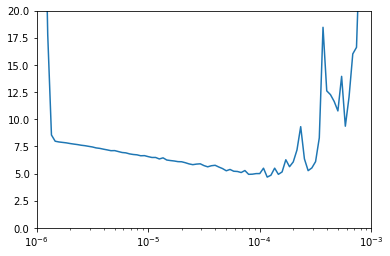

In [14]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1e-3, 0, 20])

In [15]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
31/31 [==============================] - 1s 18ms/step - loss: 46.5854 - mae: 47.9542 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/500
31/31 [==============================] - 0s 5ms/step - loss: 11.8285 - mae: 11.9459 - val_loss: 9.2357 - val_mae: 9.6871
Epoch 3/500
31/31 [==============================] - 0s 5ms/step - loss: 10.1682 - mae: 10.3805 - val_loss: 9.1530 - val_mae: 9.6008
Epoch 4/500
31/31 [==============================] - 0s 5ms/step - loss: 9.8548 - mae: 10.2880 - val_loss: 9.2402 - val_mae: 9.5627
Epoch 5/500
31/31 [==============================] - 0s 6ms/step - loss: 9.3782 - mae: 10.1772 - val_loss: 8.8791 - val_mae: 9.4029
Epoch 6/500
31/31 [==============================] - 0s 6ms/step - loss: 9.5393 - mae: 10.0866 - val_loss: 8.9816 - val_mae: 9.3764
Epoch 7/500
31/31 [==============================] - 0s 5ms/step - loss: 9.4518 - mae: 9.9598 - val_loss: 9.1477 - val_mae: 9.6448
Epoch 8/500
31/31 [==============================] - 0s 5ms/step 

Epoch 63/500
31/31 [==============================] - 0s 5ms/step - loss: 5.8499 - mae: 6.2962 - val_loss: 6.0042 - val_mae: 6.3899
Epoch 64/500
31/31 [==============================] - 0s 5ms/step - loss: 5.9194 - mae: 6.2138 - val_loss: 5.8279 - val_mae: 6.3414
Epoch 65/500
31/31 [==============================] - 0s 5ms/step - loss: 5.6132 - mae: 6.2228 - val_loss: 5.7855 - val_mae: 6.2484
Epoch 66/500
31/31 [==============================] - 0s 5ms/step - loss: 5.5265 - mae: 6.1685 - val_loss: 5.7921 - val_mae: 6.2485
Epoch 67/500
31/31 [==============================] - 0s 5ms/step - loss: 5.6643 - mae: 6.1712 - val_loss: 5.8200 - val_mae: 6.2940
Epoch 68/500
31/31 [==============================] - 0s 5ms/step - loss: 5.7893 - mae: 6.1653 - val_loss: 5.7905 - val_mae: 6.2627
Epoch 69/500
31/31 [==============================] - 0s 5ms/step - loss: 5.7449 - mae: 6.1001 - val_loss: 5.8544 - val_mae: 6.3617
Epoch 70/500
31/31 [==============================] - 0s 5ms/step - loss: 5.

Epoch 125/500
31/31 [==============================] - 0s 5ms/step - loss: 4.7197 - mae: 5.2005 - val_loss: 5.0760 - val_mae: 5.3858
Epoch 126/500
31/31 [==============================] - 0s 5ms/step - loss: 4.7288 - mae: 5.1690 - val_loss: 5.0776 - val_mae: 5.4696
Epoch 127/500
31/31 [==============================] - 0s 5ms/step - loss: 4.6851 - mae: 5.1350 - val_loss: 4.9439 - val_mae: 5.4462
Epoch 128/500
31/31 [==============================] - 0s 5ms/step - loss: 4.6963 - mae: 5.1441 - val_loss: 4.9658 - val_mae: 5.4599


In [16]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [17]:
lin_forecast = model_forecast(model, series[split_time - window_size:-1], window_size)[:, 0]

In [18]:
lin_forecast.shape

(461,)

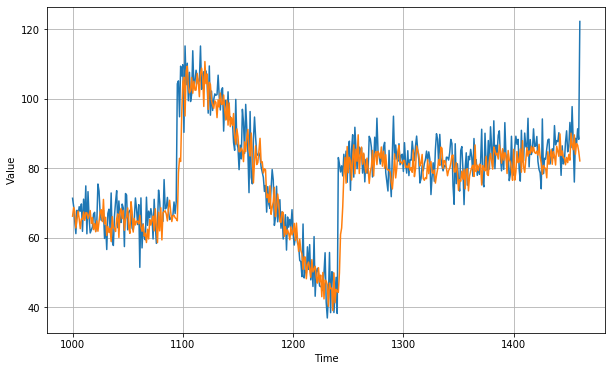

In [19]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, lin_forecast)

In [20]:
keras.metrics.mean_absolute_error(x_valid, lin_forecast).numpy()

5.3433843

### Dense Model Forecasting

In [21]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 1s 21ms/step - loss: 43.7540 - mae: 44.3312
Epoch 2/100
31/31 [==============================] - 0s 4ms/step - loss: 41.3574 - mae: 42.0073
Epoch 3/100
31/31 [==============================] - 0s 4ms/step - loss: 38.5907 - mae: 39.1402
Epoch 4/100
31/31 [==============================] - 0s 4ms/step - loss: 35.2973 - mae: 35.8227
Epoch 5/100
31/31 [==============================] - 0s 4ms/step - loss: 31.6483 - mae: 32.0831
Epoch 6/100
31/31 [==============================] - 0s 4ms/step - loss: 27.4519 - mae: 27.9021
Epoch 7/100
31/31 [==============================] - 0s 4ms/step - loss: 22.8110 - mae: 23.2716
Epoch 8/100
31/31 [==============================] - 0s 4ms/step - loss: 17.8342 - mae: 18.2723
Epoch 9/100
31/31 [==============================] - 0s 4ms/step - loss: 12.6880 - mae: 13.1545
Epoch 10/100
31/31 [==============================] - 0s 7ms/step - loss: 8.5515 - mae: 9.0650
Epoch 11/100
31/31 [====================

31/31 [==============================] - 0s 4ms/step - loss: 38.9515 - mae: 39.2942
Epoch 88/100
31/31 [==============================] - 0s 4ms/step - loss: 40.2221 - mae: 40.7964
Epoch 89/100
31/31 [==============================] - 0s 4ms/step - loss: 39.2688 - mae: 39.8229
Epoch 90/100
31/31 [==============================] - 0s 4ms/step - loss: 39.8100 - mae: 40.2596
Epoch 91/100
31/31 [==============================] - 0s 4ms/step - loss: 38.8666 - mae: 39.4736
Epoch 92/100
31/31 [==============================] - 0s 4ms/step - loss: 38.0606 - mae: 38.6213
Epoch 93/100
31/31 [==============================] - 0s 4ms/step - loss: 37.1714 - mae: 37.6336
Epoch 94/100
31/31 [==============================] - 0s 4ms/step - loss: 35.9998 - mae: 36.5564
Epoch 95/100
31/31 [==============================] - 0s 4ms/step - loss: 34.8746 - mae: 35.3420
Epoch 96/100
31/31 [==============================] - 0s 4ms/step - loss: 33.5253 - mae: 34.0044
Epoch 97/100
31/31 [=======================

[1e-07, 0.005, 0, 30]

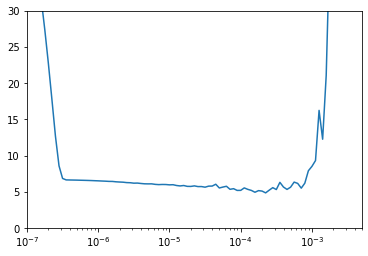

In [22]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 5e-3, 0, 30])

In [23]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
31/31 [==============================] - 1s 20ms/step - loss: 20.0238 - mae: 20.8270 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/500
31/31 [==============================] - 0s 6ms/step - loss: 8.6303 - mae: 9.0442 - val_loss: 7.8260 - val_mae: 8.3112
Epoch 3/500
31/31 [==============================] - 0s 6ms/step - loss: 8.1637 - mae: 8.4718 - val_loss: 7.6869 - val_mae: 8.1423
Epoch 4/500
31/31 [==============================] - 0s 6ms/step - loss: 7.8828 - mae: 8.1519 - val_loss: 7.1338 - val_mae: 7.4683
Epoch 5/500
31/31 [==============================] - 0s 6ms/step - loss: 7.3930 - mae: 7.8994 - val_loss: 6.8095 - val_mae: 7.3306
Epoch 6/500
31/31 [==============================] - 0s 5ms/step - loss: 7.2310 - mae: 7.6983 - val_loss: 6.6906 - val_mae: 7.0048
Epoch 7/500
31/31 [==============================] - 0s 5ms/step - loss: 6.9234 - mae: 7.5004 - val_loss: 6.5143 - val_mae: 7.0573
Epoch 8/500
31/31 [==============================] - 0s 6ms/step - loss:

31/31 [==============================] - 0s 5ms/step - loss: 5.2726 - mae: 5.7429 - val_loss: 5.1320 - val_mae: 5.5780
Epoch 64/500
31/31 [==============================] - 0s 5ms/step - loss: 5.4438 - mae: 5.6699 - val_loss: 5.0222 - val_mae: 5.5532
Epoch 65/500
31/31 [==============================] - 0s 5ms/step - loss: 5.1666 - mae: 5.6580 - val_loss: 5.3494 - val_mae: 5.7631
Epoch 66/500
31/31 [==============================] - 0s 5ms/step - loss: 5.2555 - mae: 5.6892 - val_loss: 5.0385 - val_mae: 5.5249
Epoch 67/500
31/31 [==============================] - 0s 5ms/step - loss: 5.2062 - mae: 5.6555 - val_loss: 5.1523 - val_mae: 5.6570
Epoch 68/500
31/31 [==============================] - 0s 5ms/step - loss: 5.2594 - mae: 5.6367 - val_loss: 4.9760 - val_mae: 5.5124
Epoch 69/500
31/31 [==============================] - 0s 5ms/step - loss: 5.2850 - mae: 5.6393 - val_loss: 4.9946 - val_mae: 5.4977
Epoch 70/500
31/31 [==============================] - 0s 5ms/step - loss: 5.0748 - mae: 5

In [24]:
dense_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size)[:, 0]

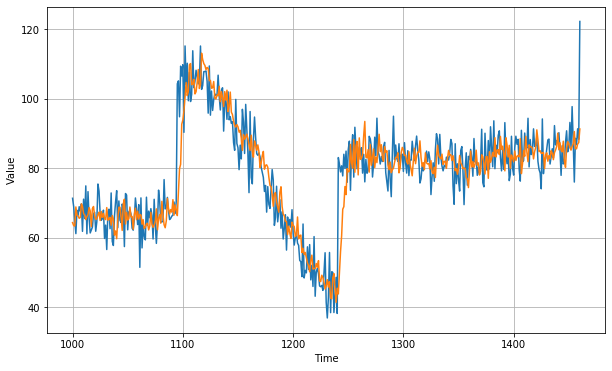

In [25]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, dense_forecast)

In [26]:
keras.metrics.mean_absolute_error(x_valid, dense_forecast).numpy()

5.299473